# Expectation Propagation

ReactiveMP comes with support for expectation propagation (EP). In this demo we illustrate EP in the context of state-estimation in a linear state-space model that combines a Gaussian state-evolution model with a discrete observation model. Here, the probit function links continuous variable $x_t$ with the discrete variable $y_t$. The model is defined as:

\begin{align}
    u &= 0.1 \\
    x_0 &\sim \mathcal{N}(0, 100) \\
    x_t &\sim \mathcal{N}(x_{t-1}+ u, 0.01) \\
    y_t &\sim \mathrm{Ber}(\Phi(x_t))
\end{align}

## Import packages

In [1]:
using StatsFuns: normcdf
using Random, Plots

using ReactiveMP, GraphPPL, Rocket, StableRNGs

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1423


##  Data generation

In [2]:
function generate_data(nr_samples::Int64; seed = 123)
    
    rng = StableRNG(seed)
    
    # hyper parameters
    u = 0.1

    # allocate space for data
    data_x = zeros(nr_samples + 1)
    data_y = zeros(nr_samples)
    
    # initialize data
    data_x[1] = -2
    
    # generate data
    for k = 2:nr_samples + 1
        
        # calculate new x
        data_x[k] = data_x[k-1] + u + sqrt(0.01)*randn(rng)
        
        # calculate y
        data_y[k-1] = normcdf(data_x[k]) > rand(rng)
        
    end
    
    # return data
    return data_x, data_y
    
end;

In [3]:
n = 40

40

In [4]:
data_x, data_y = generate_data(n);

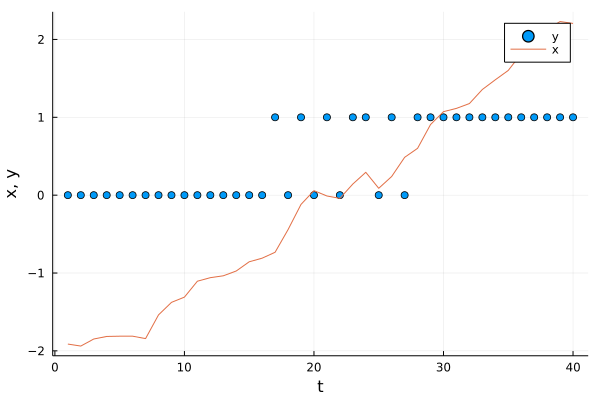

┌ Info: Precompiling GR_jll [d2c73de3-f751-5644-a686-071e5b155ba9]
└ @ Base loading.jl:1423
┌ Warning: Module FFMPEG_jll with build ID 426443658986951 is missing from the cache.
│ This may mean FFMPEG_jll [b22a6f82-2f65-5046-a5b2-351ab43fb4e5] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1107
┌ Info: Skipping precompilation since __precompile__(false). Importing GR_jll [d2c73de3-f751-5644-a686-071e5b155ba9].
└ @ Base loading.jl:1124


In [5]:
p = plot(xlabel = "t", ylabel = "x, y")
p = scatter!(p, data_y, label = "y")
p = plot!(p, data_x[2:end], label = "x")

## Model specification

In [6]:
@model function probit_model(nr_samples::Int64)
    
    # allocate space for variables
    x = randomvar(nr_samples + 1)
    y = datavar(Float64, nr_samples)
    
    # specify uninformative prior
    x[1] ~ NormalMeanPrecision(0.0, 0.01)
    
    # create model 
    for k = 2:nr_samples + 1
        x[k] ~ NormalMeanPrecision(x[k - 1] + 0.1, 100)
        y[k - 1] ~ Probit(x[k]) where {
            # Probit node by default uses RequireInbound pipeline with vague(NormalMeanPrecision) message as initial value for `in` edge
            # To change initial value use may specify it manually, like. Changes to the initial message may improve stability in some situations
            pipeline = RequireInbound(in = NormalMeanPrecision(0, 1.0)) 
        }
    end
    
    # return parameters
    return x, y
    
end;

## Inference

In [7]:
result = inference(
    model = Model(probit_model, length(data_y)), 
    data  = (
        y = data_y, 
    ), 
    iterations = 10, 
    returnvars = (
        x = KeepLast(),
    ),
    free_energy  = true
)

Inference results:
-----------------------------------------
Free Energy: Real[15.7477, 15.6467, 15.6462, 15.6462, 15.6462, 15.6462, 15.6462, 15.6462, 15.6462, 15.6462]
-----------------------------------------
x = Marginal[Marginal(NormalWeightedMeanPrecision{Float64}(xi=-11.364497027595757, w...


## Results

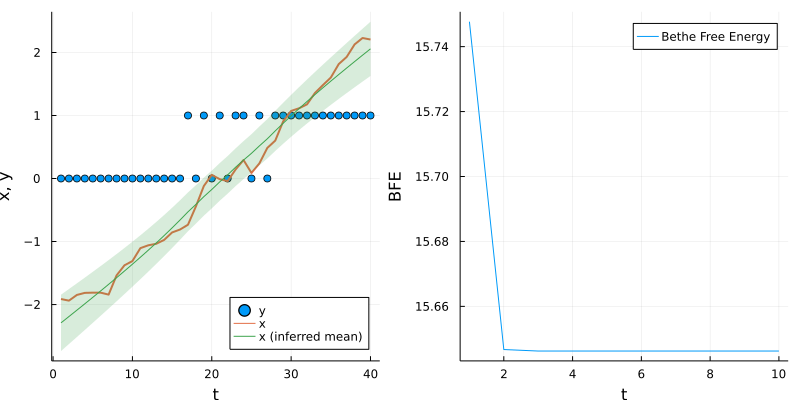

In [9]:
mx = result.posteriors[:x]

p = plot(xlabel = "t", ylabel = "x, y", legend = :bottomright)
p = scatter!(p, data_y, label = "y")
p = plot!(p, data_x[2:end], label = "x", lw = 2)
p = plot!(mean.(mx)[2:end], ribbon = std.(mx)[2:end], fillalpha = 0.2, label="x (inferred mean)")

f = plot(xlabel = "t", ylabel = "BFE")
f = plot!(result.free_energy, label = "Bethe Free Energy")

plot(p, f, size = (800, 400))